In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

import os
import time
import pandas as pd


## Pytorch_Lightning : LeNet5

- tracking the training process with Pytorch Lightning
- refer to [https://github.com/rasbt/deeplearning-models/blob/master/pytorch-lightning_ipynb/cnn/cnn-lenet5-mnist.ipynb]

In [60]:
# load datasets
DATA_PATH = './data/mnist'

class DataModule(pl.LightningDataModule):
    def __init__(self, data_path=DATA_PATH):
        super().__init__()
        self.data_path = data_path

    def prepare_data(self):
        datasets.MNIST(self.data_path, train=True, download=True)
        datasets.MNIST(self.data_path, train=False, download=True)

        self.data_transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor()])
        return
    
    def setup(self, stage=None):
        self.train = datasets.MNIST(DATA_PATH, train=True, download=True, transform=self.data_transform)
        self.val = datasets.MNIST(DATA_PATH, train=False, download=True, transform=self.data_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=32)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=32)
    
torch.manual_seed(0)
data_module = DataModule()

In [61]:
class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super().__init__()

        # colr channels or grayscale
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        # returns as logits not 0~1
        logits = self.classifier(x)
        return logits
        

In [66]:
class LightningModel(pl.LightningModule):
    def __init__(self, model, lr=0.001, num_classes=10):
        super().__init__()
        self.model = model
        self.lr = lr
        self.save_hyperparameters(ignore=['model'])
        self.train_acc = torchmetrics.Accuracy(task = 'MULTICLASS', num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task = 'MULTICLASS', num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task = 'binary')

    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, labels = batch
        logits = self.model(features)
        loss = F.cross_entropy(logits, labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, labels, predicted_labels
    
    def training_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log('train_loss', loss)
        self.model.eval()
        with torch.no_grad():
            _, labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, labels)
        self.log('train_acc', self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log('val_loss', loss)
        self.val_acc.update(predicted_labels, labels)
        self.log('val_acc', self.val_acc, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.test_acc.update(predicted_labels, labels)
        self.log('test_acc', self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.001)
        return [optimizer], [scheduler]

In [67]:
model = LeNet5(num_classes=10, grayscale=True)
lightning_model = LightningModel(model, lr=0.001)

callbacks = [ModelCheckpoint(monitor='val_acc', mode='max')]

os.makedirs('./pl_models', exist_ok=True)
# save logs to csv : lenet5_logs.csv (loss, accuracy)
logger = CSVLogger(save_dir='./pl_models', name='lenet5_logs')

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=callbacks,
    accelerator='auto',
    log_every_n_steps=5
)

start_time = time.time()
trainer.fit(lightning_model, data_module)

runtime = (time.time() - start_time) / 60
print(f"Training time: {runtime:.2f} minutes in total")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | LeNet5             | 61.7 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
-------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


/Users/minkyunjung/miniforge3/envs/condavenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/minkyunjung/miniforge3/envs/condavenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1875/1875 [00:32<00:00, 57.38it/s, v_num=5, val_acc=0.987]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1875/1875 [00:32<00:00, 57.36it/s, v_num=5, val_acc=0.987]
Training time: 5.50 minutes in total


<Axes: xlabel='Epoch', ylabel='Accuracy'>

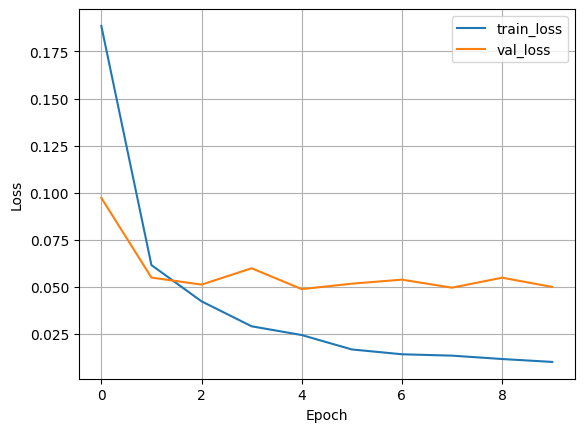

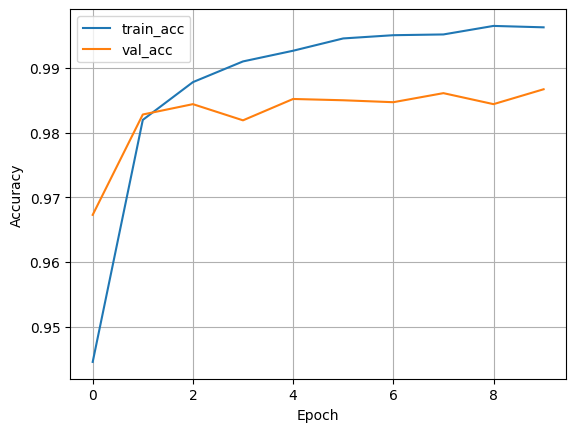

In [68]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

aggreg_metrics = []
agg_col = 'epoch'

for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'val_loss']].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[['train_acc', 'val_acc']].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Accuracy')